In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

I need to figure out a way of translating the river mouth locations to the grid from the model. 

Idea:

- Detect the coastal cell that is closer to the river mouth. 
- Create the cluster using that cell. 

In [261]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def rivers_per_location(DF, loc_coords, radius, binned=False):
    """
    Input
    - DF: the pandas Dataframe with data River_sources. 
    - loc_coords: tuple with the location coordinates as in (lat, lon).
    - radius: the radius in degrees around loc_coords.
    Returns 
    - the dataframe around loc_coords.
    """
    if binned:
        _label = '_bin'
        
    else:
        _label = ''
        
    x_col = f'X{_label}'
    y_col = f'Y{_label}'
    
    lat, lon = loc_coords
    mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
    new_DF = DF[mask]
    return new_DF, mask

def region_filters(DF, lon_min, lon_max, lat_min, lat_max):
    """
    DF is the River_sources dataframes. lat_min, lat_max, lon_min, lon_max are the domain limits.
    Returns the dataframe only for the region.
    """
    mask = (DF['X'] <= lon_max) & (DF['X'] > lon_min) & (DF['Y'] <= lat_max) & (DF['Y'] > lat_min)
    new_DF = DF[mask]
    return new_DF

In [123]:
river_sources = pd.read_csv('../data/sources/Lebreton_rivers/PlasticRiverInputs.csv')

In [4]:
coastal_fields = xr.load_dataset('../coastal_fields.nc')

In [6]:
coast = coastal_fields.coastal.values
lats = coastal_fields.lat.values
lons = coastal_fields.lon.values

X = coastal_fields.lon_mesh
Y = coastal_fields.lat_mesh

In [122]:
iy_coast, ix_coast = np.where(coast==1)
lat_coast = lats[iy_coast]
lon_coast = lons[ix_coast]

In [38]:
def nearest_coastal_cell(latidute, longitude, coord_lat, coord_lon):    
    """
    Function to find the index of the closest point to a certain lon/lat value.
    
    latidute and longitude are the dimensinal 1D arrays of the grid, with the same length.
    coord_lat and coord_lon are the coordinates of a point.
    """
    
    distance = np.sqrt((longitude-coord_lon)**2 + (latidute-coord_lat)**2)                     
    index = distance.argmin()               
        
    return index

In [29]:
nearest_coastal_cell(lat_coast, lon_coast, -10, -30)

4777

We select a smaller region for the analysis.

In [11]:
South_Atlantic_region = (-70, 25, -50, -5)

In [12]:
SA_rivers = region_filters(river_sources, *South_Atlantic_region)

In [14]:
sorted_rivers = SA_rivers.sort_values('i_high', ascending=False)
sorted_rivers = sorted_rivers.reset_index()

-35.0375 -6.2875
4833
-35.0 -6.3333335


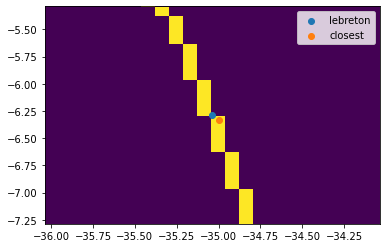

In [39]:
N = 300

x_lon = sorted_rivers.iloc[N].X
x_lat = sorted_rivers.iloc[N].Y

print(x_lon, x_lat)
n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
print(n_index)
print(lon_coast[n_index], lat_coast[n_index])

res = 1
plt.pcolormesh(X,Y, coast,shading='auto')
plt.scatter(x_lon, x_lat, label='lebreton')
plt.scatter(lon_coast[n_index], lat_coast[n_index], label='closest')
plt.xlim(x_lon-res, x_lon+res)
plt.ylim(x_lat-res, x_lat+res)
plt.legend()

In [253]:
N = 1500
coordinates = np.zeros((N, 2))

for i in range(N):
    x_lon = sorted_rivers.iloc[i].X
    x_lat = sorted_rivers.iloc[i].Y

    n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
    coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])

In [254]:
lons.min(), lons.max()

(-73.0, 24.916666)

In [255]:
hist, _,_ = np.histogram2d(coordinates[:, 0], coordinates[:, 0], bins=coast.shape,
                            range=[[lons.min(), lons.max()], [lats.min(), lats.max()]])

In [258]:
np.sum(hist)

975.0

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


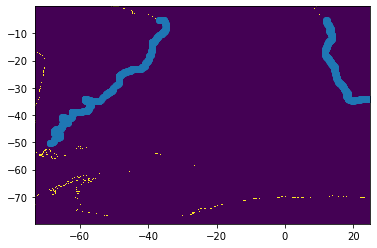

In [259]:
plt.pcolormesh(X, Y, coast)
plt.scatter(coordinates[:,0], coordinates[:, 1])

In [131]:
len(SA_rivers)

1512

In [153]:
def rivers2coastalgrid(DF, coastal_fields):
    
    N = len(DF)
    
    coast = coastal_fields.coastal.values
    lats = coastal_fields.lat.values
    lons = coastal_fields.lon.values
    iy_coast, ix_coast = np.where(coast==1)
    lat_coast = lats[iy_coast]
    lon_coast = lons[ix_coast]

    new_coordinates = np.zeros((N, 2)) 

    for i in range(N):
        x_lon = DF.iloc[i].X
        x_lat = DF.iloc[i].Y

        n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
        new_coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])
        
    aux = pd.DataFrame(new_coordinates, columns=['X_bin', 'Y_bin'], index=DF.index)
    new_DF = pd.concat([DF, aux], axis=1)
    
    return new_DF

In [334]:
binned_rivers = rivers2coastalgrid(SA_rivers, coastal_fields)

In [335]:
binned_rivers

,X,Y,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,...,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,X_bin,Y_bin
2452,0.000000,-5.037500,3.599665,1.757410,10.497470,0.330902,0.156224,0.999232,0.629068,0.310066,...,0.112929,0.040477,0.027014,0.363428,4.973089,3.328626,1.135720e+06,7.365000e+08,0.000000,-0.083333
2457,12.104167,-5.162500,0.014340,0.005125,0.058823,0.001049,0.000355,0.004558,0.002631,0.000944,...,0.137236,0.047556,0.033318,0.794878,11.040690,5.915197,1.593680e+04,3.590000e+07,12.083333,-5.166667
2459,12.137500,-5.204167,160.931626,97.080530,372.223891,18.050214,10.741337,42.337150,26.878723,16.464646,...,0.124746,0.032019,0.022962,0.298411,2.550895,2.562979,1.620320e+07,1.317420e+10,12.166667,-5.250000
2468,12.212500,-5.429167,0.031909,0.011892,0.125015,0.002021,0.000710,0.008423,0.005377,0.002012,...,0.210617,0.046489,0.028424,1.783523,13.120873,7.033172,2.128220e+04,5.210000e+07,12.166667,-5.416667
2470,12.220833,-5.462500,1.342190,0.619845,4.160276,0.092403,0.040520,0.302452,0.233546,0.108698,...,0.242650,0.068841,0.047406,1.576548,12.078950,6.841939,2.573060e+05,4.513000e+08,12.166667,-5.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39564,-68.620833,-49.945833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.187116,0.179610,0.148997,0.100616,0.079531,0.076160,8.291300e+01,3.040000e+07,-68.583336,-50.250000
39565,-68.504167,-49.945833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.209314,0.197067,0.168909,0.113787,0.083872,0.074368,4.376000e+01,1.490000e+07,-68.333336,-50.166668
39568,-68.620833,-49.962500,0.004789,0.001536,0.022060,0.000426,0.000137,0.001959,0.000402,0.000129,...,0.584262,0.535072,0.715400,0.818855,0.831618,0.801182,4.251450e+04,2.705620e+10,-68.583336,-50.250000
39570,-67.870833,-49.970833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.280626,0.268234,0.258034,0.211518,0.170115,0.151919,3.817000e+01,1.490000e+07,-67.916664,-50.000000


In [344]:
group_bins = binned_rivers.groupby(['X_bin', 'Y_bin']).sum()

In [358]:
group_bins.reset_index(inplace=True)

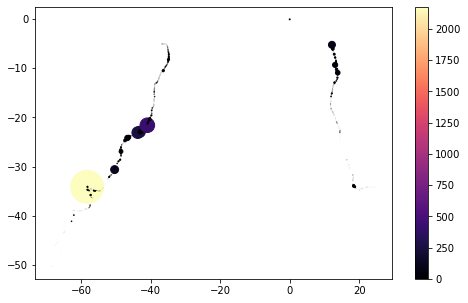

In [374]:
plt.figure(figsize=(8,5))
#plt.pcolormesh(X, Y, coast)
im = plt.scatter(group_bins['X_bin'], group_bins['Y_bin'], c=group_bins['i_low'],
                 s=group_bins['i_low']/2, cmap='magma', edgecolors=None)
plt.colorbar(im)

In [375]:
cluster_locations = {'Luanda':(-8.82, 13.22),
                     'Cuvo':(-10.87917, 13.81250),
                     'Chiloango-Congo':(-5.6442, 12.1375),
                     'Cape-Town':(-33.93, 18.56),
                    'Rio-de-la-Plata':(-33.9375, -58.5208),
                    'Porto-Alegre':(-30.051, -51.285),
                    'Santos':(-23.9875, -46.2958),
                    'Paraiba':(-21.6208, -41.0375),
                    'Itajai':(-26.9125, -48.6458),
                    'Rio-de-Janeiro':(-23.01250, -43.32083)}

In [ ]:
la

In [381]:
grid_cluster_centers = {}
for loc in cluster_locations:

    indx = nearest_coastal_cell(lat_coast, lon_coast, *cluster_locations[loc])
    grid_cluster_centers[loc] = (lat_coast[indx], lon_coast[indx])

In [382]:
grid_cluster_centers

{'Luanda': (-8.833333, 13.25),
 'Cuvo': (-10.916667, 13.833333),
 'Chiloango-Congo': (-5.6666665, 12.083333),
 'Cape-Town': (-33.916668, 18.416666),
 'Rio-de-la-Plata': (-34.083332, -58.333332),
 'Porto-Alegre': (-30.583334, -50.416668),
 'Santos': (-24.0, -46.333332),
 'Paraiba': (-21.583334, -41.0),
 'Itajai': (-26.916666, -48.583332),
 'Rio-de-Janeiro': (-23.0, -43.333332)}

# Overkill solution

In [329]:
def rivers2coastalgrid_2(DF, coastal_fields):
    
    N = len(DF)
    
    Bin_DF = pd.DataFrame()
    
    coast = coastal_fields.coastal.values
    lats = coastal_fields.lat.values
    lons = coastal_fields.lon.values
    dx = np.diff(lons)[0]
    
    iy_coast, ix_coast = np.where(coast==1)
    lat_coast = lats[iy_coast]
    lon_coast = lons[ix_coast]

    new_coordinates = np.zeros((N, 2)) 

    for i in range(N):
        x_lon = DF.iloc[i].X
        x_lat = DF.iloc[i].Y

        n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
        new_coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])
        
    aux = pd.DataFrame(new_coordinates, columns=['X_bin', 'Y_bin'], index=DF.index)
    DF = pd.concat([DF, aux], axis=1)
    
    L = len(lat_coast)
    
    for j in range(L):
        
        bin_mask = rivers_per_location(DF, (lat_coast[j], lon_coast[j]), dx/2, binned=True)
        
        if bin_mask.sum() > 0:
            series = DF[bin_mask].sum().to_frame()
            series
            Bin_DF = pd.concat([Bin_DF, series], axis=1)
            
    Bin_DF = Bin_DF.T
    Bin_DF = Bin_DF.reset_index()
    Bin_DF = Bin_DF.drop(['index', 'X', 'Y'], axis=1)
    
    return Bin_DF

In [330]:
binned_rivers = rivers2coastalgrid_2(SA_rivers, coastal_fields)

In [331]:
binned_rivers

,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,i_high_feb,i_mid_mar,...,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,X_bin,Y_bin
0,0.006420,0.002029,0.030079,0.000594,0.000188,0.002776,0.000522,0.000165,0.002436,0.000456,...,1.275802,1.136191,1.378335,1.437603,1.371964,1.351435,76543.190,4.542030e+10,-274.333344,-201.000000
1,0.000002,0.000000,0.000013,0.000000,0.000000,0.000001,0.000000,0.000000,0.000001,0.000000,...,0.590872,0.562548,0.472751,0.317295,0.239723,0.223380,1564.809,5.068000e+08,-205.000008,-150.500004
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.280626,0.268234,0.258034,0.211518,0.170115,0.151919,38.170,1.490000e+07,-67.916664,-50.000000
3,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.561252,0.536468,0.516073,0.423039,0.340224,0.303836,251.043,9.570000e+07,-135.666672,-99.833336
4,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.584076,0.547501,0.512261,0.406353,0.322592,0.284390,403.819,1.475000e+08,-135.500000,-99.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.007258,0.002439,0.031888,0.000136,0.000040,0.000684,0.000285,0.000089,0.001354,0.000898,...,3.812479,1.195510,0.737703,0.446491,0.317489,0.659113,27015.730,2.728000e+08,-73.666664,-10.000000
908,0.000318,0.000091,0.001658,0.000002,0.000001,0.000016,0.000007,0.000002,0.000042,0.000053,...,0.777333,0.383870,0.212927,0.144525,0.110292,0.111852,5643.460,6.930000e+07,-36.000000,-5.000000
909,0.003897,0.001296,0.017305,0.000022,0.000006,0.000122,0.000072,0.000021,0.000367,0.000648,...,0.570991,0.315397,0.182243,0.122829,0.093750,0.089655,33336.900,2.591000e+08,-35.916668,-5.000000
910,0.002454,0.000795,0.011214,0.000014,0.000004,0.000078,0.000044,0.000012,0.000231,0.000394,...,0.537426,0.295928,0.171681,0.116195,0.088978,0.084943,25921.600,1.856000e+08,-35.833332,-5.000000


/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


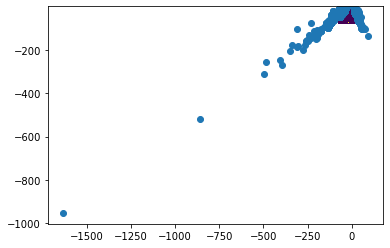

In [333]:
plt.pcolormesh(X, Y, coast)
plt.scatter(binned_rivers['X_bin'], binned_rivers['Y_bin'])

Overkill and wrong :sad: